In [1]:
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from tensorflow import keras as k
import numpy as np

2023-08-31 21:53:12.853743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
crimes = pd.read_csv("neighborhood_crimes_encoded.csv")

In [3]:
crimes.head()

,neighborhood_code,city_code,estacao,ano,mes,dia,mes_sin,mes_cos,dia_sin,dia_cos,periodo,pontos
0,3887,202,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107991.0
1,699,43,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107530.0
2,711,43,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107529.0
3,4991,305,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108027.0
4,4991,305,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108027.0


<AxesSubplot:>

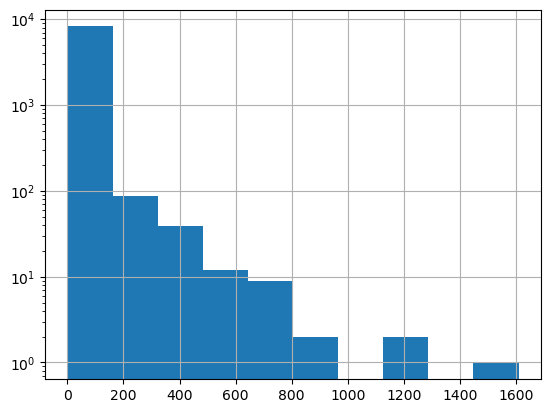

In [4]:
crimes.groupby("neighborhood_code").size().hist(log=True)

In [5]:
X_date = crimes[["estacao", "ano", "mes_sin", "mes_cos", "dia_sin", "dia_cos", "periodo"]].values
X_location = crimes["neighborhood_code"]
X = {"location_code": X_location, "date_features": X_date}

In [6]:
y = crimes["pontos"]
y = y / y.max()

In [7]:
num_locations = crimes["neighborhood_code"].max() + 1
num_locations

8400

In [8]:
k.utils.set_random_seed(42)

In [9]:
location = k.layers.Input(shape=(1,), name="location_code")
date_components = k.layers.Input(shape=(7,), name="date_features")

In [10]:
def embedding_block(input_layer, num_cat, out_dim):
    x = k.layers.Embedding(num_cat, out_dim)(input_layer)
    x = k.layers.Flatten()(x)
    return x

In [11]:
location_embedding = embedding_block(location, num_locations, 5)

2023-08-31 21:53:15.680456: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
normalizer = k.layers.Normalization()
normalizer.adapt(X_date)

In [13]:
time_normalization = normalizer(date_components)
concat_layer = k.layers.concatenate([location_embedding, time_normalization])
hidden_layer = k.layers.Dense(32, activation="relu", name="hidden")(concat_layer)
output_layer = k.layers.Dense(1, activation="sigmoid", name="output")(hidden_layer)

In [14]:
model = k.Model([location, date_components], output_layer)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 location_code (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         42000       ['location_code[0][0]']          
                                                                                                  
 date_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 5)            0           ['embedding[0][0]']              
                                                                                              

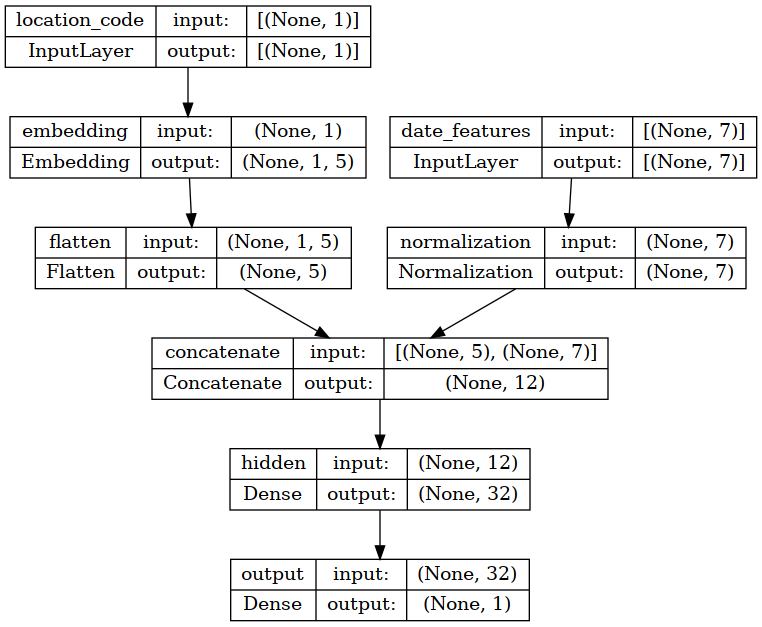

In [16]:
k.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer="Adam", loss="mean_absolute_error", metrics=[
    "mean_squared_error",
    "mean_absolute_percentage_error"
    ]
)

In [18]:
model.fit(X, y, batch_size=1_000, epochs=10, validation_split=.2, callbacks=[k.callbacks.TensorBoard()])

Epoch 1/10
99/99 [==============================] - 1s 7ms/step - loss: 0.1488 - mean_squared_error: 0.0361 - mean_absolute_percentage_error: 19.7232 - val_loss: 0.1269 - val_mean_squared_error: 0.0187 - val_mean_absolute_percentage_error: 22.0506
Epoch 2/10
99/99 [==============================] - 1s 11ms/step - loss: 0.0560 - mean_squared_error: 0.0056 - mean_absolute_percentage_error: 7.9772 - val_loss: 0.1132 - val_mean_squared_error: 0.0161 - val_mean_absolute_percentage_error: 19.4355
Epoch 3/10
99/99 [==============================] - 3s 26ms/step - loss: 0.0293 - mean_squared_error: 0.0019 - mean_absolute_percentage_error: 4.1631 - val_loss: 0.0705 - val_mean_squared_error: 0.0068 - val_mean_absolute_percentage_error: 11.9528
Epoch 4/10
99/99 [==============================] - 3s 25ms/step - loss: 0.0193 - mean_squared_error: 8.4471e-04 - mean_absolute_percentage_error: 2.6559 - val_loss: 0.0398 - val_mean_squared_error: 0.0023 - val_mean_absolute_percentage_error: 6.6859
Epoch

In [19]:
mse, mae, mape = model.evaluate(X, y)
print(f"MSE {mse} | MAE: {mae} | MAPE: {mape}")

   1/3838 [..............................] - ETA: 1:05 - loss: 0.0088 - mean_squared_error: 9.3127e-05 - mean_absolute_percentage_error: 1.7032

3838/3838 [==============================] - 5s 1ms/step - loss: 0.0103 - mean_squared_error: 2.5551e-04 - mean_absolute_percentage_error: 1.5382
MSE 0.01031782478094101 | MAE: 0.0002555130049586296 | MAPE: 1.5381910800933838


In [20]:
y_pred = model.predict(X)

3838/3838 [==============================] - 5s 1ms/step


(array([  984.,  5896., 11294., 12887., 19006., 18797., 16801., 15672.,
         8126., 13345.]),
 array([0.3752113 , 0.43397892, 0.49274656, 0.5515142 , 0.6102818 ,
        0.66904944, 0.72781706, 0.7865847 , 0.84535235, 0.90411997,
        0.9628876 ], dtype=float32),
 <BarContainer object of 10 artists>)

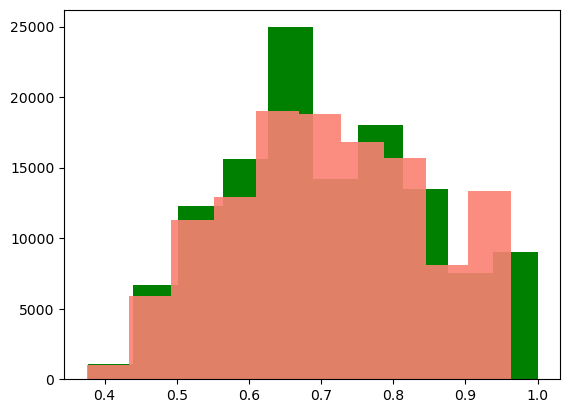

In [21]:
plt.hist(y, color="green")
plt.hist(y_pred, color="salmon", alpha=.9)

In [22]:
crimes["pred"] = y_pred
crimes["score"] = y

<AxesSubplot:xlabel='neighborhood_code'>

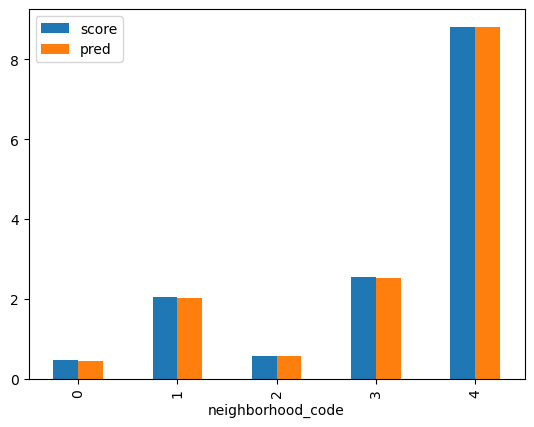

In [23]:
crimes.groupby("neighborhood_code")[["score", "pred"]].sum().head().plot(kind="bar")

<AxesSubplot:xlabel='mes'>

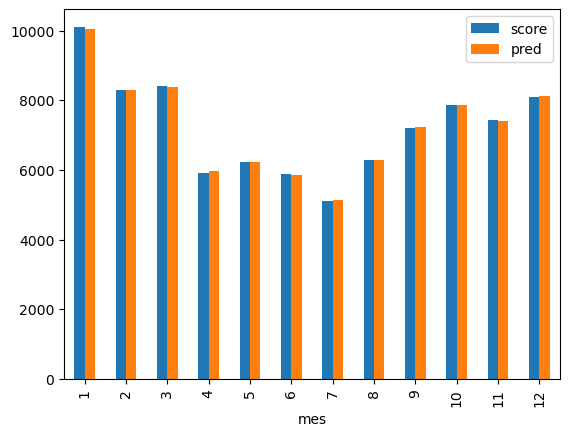

In [24]:
crimes.groupby("mes")[["score", "pred"]].sum().plot(kind="bar")

In [25]:
crimes["abs_error"] = np.absolute(crimes["score"] - crimes["pred"])

In [26]:
crimes.sort_values(by="abs_error", ascending=False).head(30)

,neighborhood_code,city_code,estacao,ano,mes,dia,mes_sin,mes_cos,dia_sin,dia_cos,periodo,pontos,pred,score,abs_error
106162,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106026,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106024,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106025,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106161,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106027,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106163,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106164,6710,358,4,2022,9,3,-1.000000e+00,-1.836970e-16,0.587785,0.809017,0,151428.0,0.835097,0.648483,0.186614
106812,6862,358,2,2022,3,18,1.000000e+00,6.123234e-17,-0.587785,-0.809017,1,164519.0,0.871692,0.704545,0.167147
108153,6710,358,2,2022,3,4,1.000000e+00,6.123234e-17,0.743145,0.669131,0,148341.0,0.802317,0.635263,0.167053


In [27]:
hidden_dense = model.get_layer("hidden")
kernel, bias = hidden_dense.trainable_weights

In [28]:
kernel.numpy().shape

(12, 32)

(array([ 2.,  1.,  4.,  7.,  0., 12.,  5.,  0.,  0.,  1.]),
 array([-0.22119974, -0.16463986, -0.10807997, -0.05152009,  0.0050398 ,
         0.06159968,  0.11815956,  0.17471945,  0.23127933,  0.2878392 ,
         0.3443991 ], dtype=float32),
 <BarContainer object of 10 artists>)

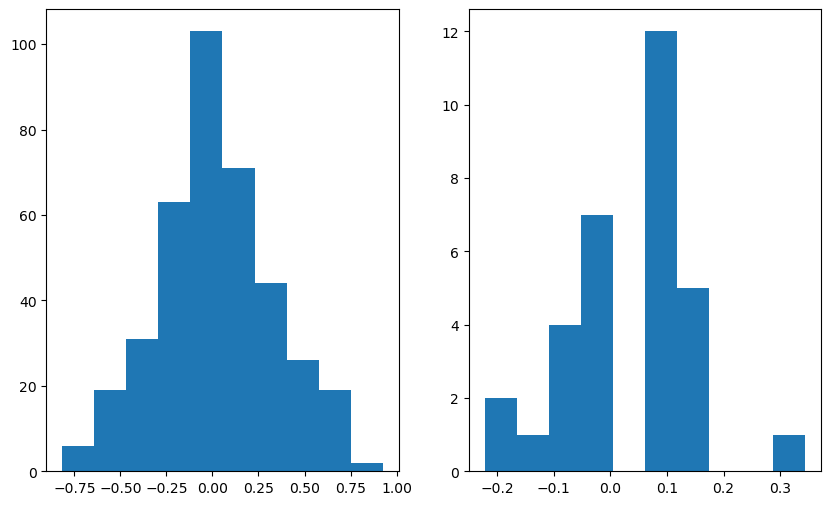

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(kernel.numpy().ravel())
ax2.hist(bias.numpy())

In [30]:
def sin_transform(x, period):
    return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
    return np.cos(x / period * 2 * np.pi)

In [31]:
obs = {"periodo": 1}
start = date(2023, 4, 1)
obs_lst = []
for i in range(365):
    dt = start + timedelta(days=i)
    aux = {
        "ano": dt.year,
        "mes": dt.month,
        "dia": dt.day,
        "estacao": (dt.month % 12) // 3 + 1,
    }
    obs_lst.append(aux)
obs_lst = pd.DataFrame(obs_lst)
obs_lst.loc[:, "mes_sin"] = sin_transform(obs_lst["mes"], 12)
obs_lst.loc[:, "mes_cos"] = cos_transform(obs_lst["mes"], 12)
obs_lst.loc[:, "dia_sin"] = sin_transform(obs_lst["dia"], 30)
obs_lst.loc[:, "dia_cos"] = cos_transform(obs_lst["dia"], 30)
obs_lst["location_code"] = 900
obs_lst["periodo"] = 1
obs_lst = {"location_code": obs_lst["location_code"], "date_features": obs_lst[["estacao", "ano", "mes_sin", "mes_cos", "dia_sin", "dia_cos", "periodo"]]}

In [32]:
forecast_result = model.predict(obs_lst)

12/12 [==============================] - 0s 4ms/step


(array([ 43.,  27.,  20.,   0.,   2.,  29.,  60., 107.,  46.,  31.]),
 array([0.19503872, 0.2149575 , 0.23487629, 0.25479507, 0.27471387,
        0.29463264, 0.31455144, 0.3344702 , 0.354389  , 0.37430778,
        0.39422658], dtype=float32),
 <BarContainer object of 10 artists>)

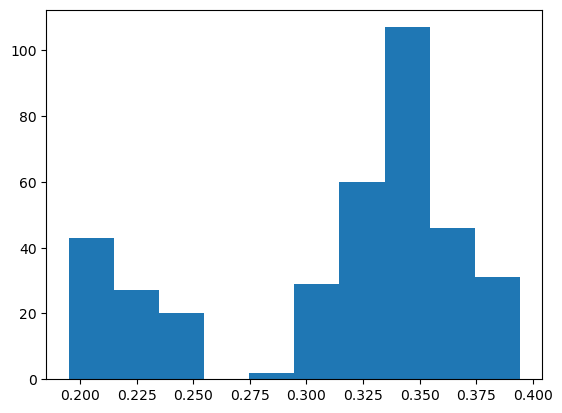

In [33]:
plt.hist(forecast_result)

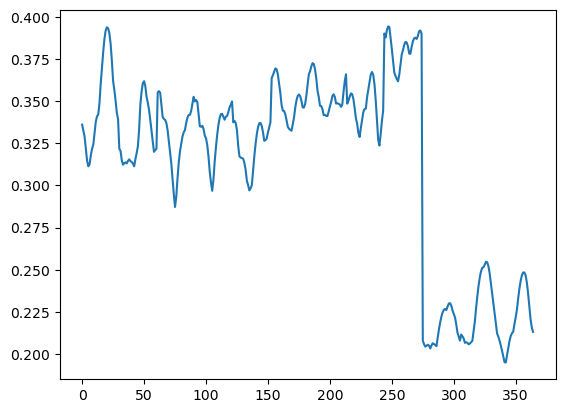

In [34]:
plt.plot(forecast_result)

In [35]:
model.save("../models/score/scoreV2_full")

INFO:tensorflow:Assets written to: ../models/score/scoreV2_full/assets


INFO:tensorflow:Assets written to: ../models/score/scoreV2_full/assets
